<a href="https://colab.research.google.com/github/rlagp12/BIO165_final-project/blob/main/BIO165_final_DeSeq2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Logistics

This is part of the code that uses DeSeq2 package for identification of differentially expressed genes in cells, expressing TST to different extent.

In [ ]:
# run this if you have not installed pyDESeq2 or umap-learn
!pip install pyDESeq2
!pip install umap-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=99a6d455319314f98c8a32bf1604d2a02ac0154b46680fe005eb227f70f325a3
  Stored in directory: /root/.cache/pip/wheels/4e/56/35/a748fc57279a4b84d0b332879445fed1ad8478e7257986b015
Successfully built session-info


In [ ]:
# the first step for most code

# import libraries

# standard libraries
import os
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt

# differential expression
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

# dimentionality reduction and clustering
from sklearn.decomposition import PCA
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
import umap
# Anaconda should automatically install all of these libraries, but if this does not work you might not
# have these libraries installed. If this is the case, you can install them using pip install.

In [ ]:
# bulk data
bulk_data = pd.read_csv("/content/karim_etal_data.csv", sep=',',index_col = 0).T
bulk_data

Geneid,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000237613,ENSG00000268020,ENSG00000240361,ENSG00000186092,ENSG00000238009,ENSG00000239945,...,ENSG00000273532,ENSG00000276351,ENSG00000275661,ENSG00000277856,ENSG00000275063,ENSG00000271254,ENSG00000275405,ENSG00000275987,ENSG00000277475,ENSG00000268674
1,0,41,0,3,0,0,0,0,0,0,...,0,0,0,0,0,249,0,0,3,0
2,0,66,0,2,0,0,0,0,0,0,...,0,0,0,0,0,372,0,1,0,0
3,0,63,0,0,0,0,0,0,0,0,...,0,0,0,0,0,221,0,0,0,0
4,0,37,0,3,0,0,0,0,0,0,...,0,0,0,0,0,274,0,1,0,0
5,0,39,0,0,0,0,0,0,0,0,...,0,0,0,0,0,232,0,0,0,0
6,0,50,0,0,0,0,1,0,0,0,...,0,0,0,0,0,235,0,0,0,0
7,0,52,4,0,0,0,0,0,0,0,...,0,0,0,0,0,259,0,0,0,0
8,0,51,0,0,0,0,0,0,0,0,...,0,0,0,0,0,237,0,0,0,0
9,0,34,1,1,0,0,0,0,0,0,...,0,0,0,0,0,130,0,0,1,0
10,0,41,2,0,0,0,0,0,0,0,...,0,0,0,0,0,114,0,0,0,0


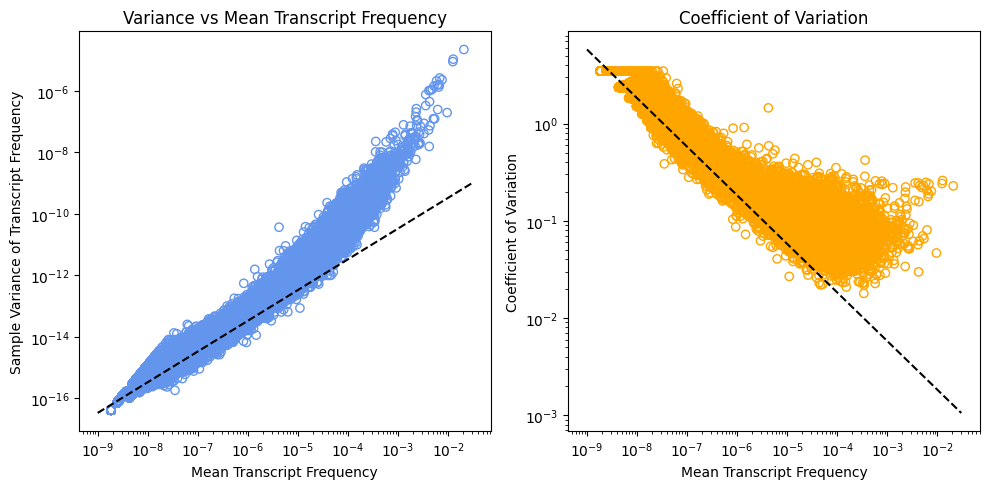

In [ ]:
# SOLUTION
bulk_data_normalized = bulk_data.div(bulk_data.sum(axis=1), axis=0)
bulk_data_normalized

# compare mean to variance - see that poisson actually isn't a good deascription
mean_values = bulk_data_normalized.mean()
var_values = bulk_data_normalized.var()

# Create the figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
freq_values = np.linspace(1E-9, 3E-2, 100)
n_samples = bulk_data.shape[0] #number of samples
n_transcripts = bulk_data.shape[1]
total_reads = bulk_data.values.sum()
n_reads = int(total_reads/n_samples) # number of reads per sample (sequencing depth)

ax1.plot(freq_values, freq_values/n_reads, c="black", ls="--")
ax1.scatter(mean_values, var_values, facecolor="none", edgecolor='cornflowerblue')
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set_xlabel("Mean Transcript Frequency")
ax1.set_ylabel("Sample Variance of Transcript Frequency")
ax1.set_title("Variance vs Mean Transcript Frequency")

# Second subplot
ax2.scatter(mean_values, bulk_data_normalized.std(ddof=1)/mean_values, facecolor="none", edgecolor='orange')
ax2.plot(freq_values, np.sqrt(1/(freq_values*n_reads)), c="black", ls="--")
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel("Mean Transcript Frequency")
ax2.set_ylabel("Coefficient of Variation")
ax2.set_title("Coefficient of Variation")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

# DeSeq analysis
## Data obtained from the RNAseq data was analysed and condition pairs were compared: overTST or shTST vs WT

In [ ]:
bulk_data
bulk_data["Condition"] = ["WT"] * 4 + ["shTST"] * 4 + ["overTST"] * 4
bulk_data.head()

Geneid,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000237613,ENSG00000268020,ENSG00000240361,ENSG00000186092,ENSG00000238009,ENSG00000239945,...,ENSG00000276351,ENSG00000275661,ENSG00000277856,ENSG00000275063,ENSG00000271254,ENSG00000275405,ENSG00000275987,ENSG00000277475,ENSG00000268674,Condition
1,0,41,0,3,0,0,0,0,0,0,...,0,0,0,0,249,0,0,3,0,WT
2,0,66,0,2,0,0,0,0,0,0,...,0,0,0,0,372,0,1,0,0,WT
3,0,63,0,0,0,0,0,0,0,0,...,0,0,0,0,221,0,0,0,0,WT
4,0,37,0,3,0,0,0,0,0,0,...,0,0,0,0,274,0,1,0,0,WT
5,0,39,0,0,0,0,0,0,0,0,...,0,0,0,0,232,0,0,0,0,shTST


In [ ]:

# SOLUTION

rep_cluster_labels = bulk_data.Condition
bulk_data = bulk_data.drop(["Condition"], axis=1)
bulk_data


Geneid,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000237613,ENSG00000268020,ENSG00000240361,ENSG00000186092,ENSG00000238009,ENSG00000239945,...,ENSG00000273532,ENSG00000276351,ENSG00000275661,ENSG00000277856,ENSG00000275063,ENSG00000271254,ENSG00000275405,ENSG00000275987,ENSG00000277475,ENSG00000268674
1,0,41,0,3,0,0,0,0,0,0,...,0,0,0,0,0,249,0,0,3,0
2,0,66,0,2,0,0,0,0,0,0,...,0,0,0,0,0,372,0,1,0,0
3,0,63,0,0,0,0,0,0,0,0,...,0,0,0,0,0,221,0,0,0,0
4,0,37,0,3,0,0,0,0,0,0,...,0,0,0,0,0,274,0,1,0,0
5,0,39,0,0,0,0,0,0,0,0,...,0,0,0,0,0,232,0,0,0,0
6,0,50,0,0,0,0,1,0,0,0,...,0,0,0,0,0,235,0,0,0,0
7,0,52,4,0,0,0,0,0,0,0,...,0,0,0,0,0,259,0,0,0,0
8,0,51,0,0,0,0,0,0,0,0,...,0,0,0,0,0,237,0,0,0,0
9,0,34,1,1,0,0,0,0,0,0,...,0,0,0,0,0,130,0,0,1,0
10,0,41,2,0,0,0,0,0,0,0,...,0,0,0,0,0,114,0,0,0,0


# This is for overTST vs WT

In [ ]:
# differential expression analysis
# no need to edit this block

# Prepare the count matrix (proline_counts)
count_matrix = bulk_data.values  # Convert to numpy array
genes = bulk_data.columns  # Gene names
samples = bulk_data.index  # Sample names

# Prepare the condition labels (kmeans_labels)
condition_labels = rep_cluster_labels  # Condition labels (0 or 1 from k-means)

# Ensure that condition_labels corresponds to the sample order
if len(condition_labels) != len(samples):
    raise ValueError("Condition labels must match the number of samples.")

# 3. Create the DeseqDataSet object
# Create a metadata dataframe for conditions
metadata = pd.DataFrame({'condition': condition_labels}, index=samples)

# Create the DeseqDataSet using count matrix and metadata
dds = DeseqDataSet(counts=count_matrix, metadata=metadata)


# Initialize inference engine
inference = DefaultInference(n_cpus=8)

# Create the DESeq2 dataset
dds = DeseqDataSet(
    counts=count_matrix,
    metadata=metadata,
)

dds.deseq2()
# Extract results
res = DeseqStats(dds, contrast=["condition", "overTST", "WT"])
res.summary()

# Get the results as a DataFrame
DE_results_df = res.results_df
DE_results_df["gene_name"] = list(bulk_data.columns)
display(DE_results_df.head())

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.04 seconds.

Fitting dispersions...
... done in 34.66 seconds.

Fitting dispersion trend curve...
... done in 1.06 seconds.

Fitting MAP dispersions...
... done in 38.15 seconds.

Fitting LFCs...
... done in 25.35 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 13.87 seconds.



Log2 fold change & Wald test p-value: condition overTST vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
0        0.000000             NaN       NaN       NaN           NaN       NaN
1       44.423694       -0.015745  0.246878 -0.063775  9.491491e-01  0.971015
2        0.678557        2.926602  2.579213  1.134688  2.565061e-01       NaN
3        0.843199       -0.945326  1.735374 -0.544739  5.859328e-01       NaN
4        0.000000             NaN       NaN       NaN           NaN       NaN
...           ...             ...       ...       ...           ...       ...
57495  206.716906       -0.583825  0.111836 -5.220374  1.785623e-07  0.000002
57496    0.000000             NaN       NaN       NaN           NaN       NaN
57497    0.128624       -0.880281  4.051553 -0.217270  8.279980e-01       NaN
57498    0.318246       -0.889074  3.443010 -0.258226  7.962327e-01       NaN
57499    0.000000             NaN       NaN       NaN           NaN       NaN

[

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
0,0.000000,NaN,NaN,NaN,NaN,NaN,ENSG00000223972
1,44.423694,-0.015745,0.246878,-0.063775,0.949149,0.971015,ENSG00000227232
2,0.678557,2.926602,2.579213,1.134688,0.256506,NaN,ENSG00000278267
3,0.843199,-0.945326,1.735374,-0.544739,0.585933,NaN,ENSG00000243485
4,0.000000,NaN,NaN,NaN,NaN,NaN,ENSG00000237613


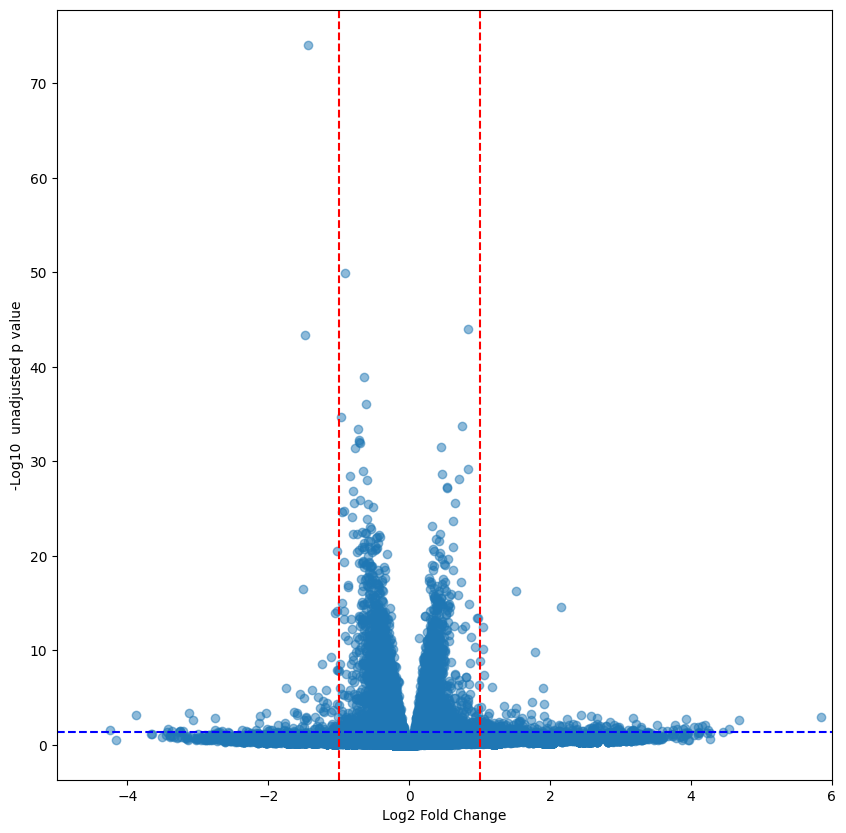

In [ ]:
# SOLUTION
plt.figure(figsize=(10,10))
plt.scatter(DE_results_df.log2FoldChange, -np.log10(DE_results_df.pvalue), alpha = 0.5)


# Add significance thresholds
plt.axhline(-np.log10(0.05), linestyle="--", color="blue")
plt.axvline(1, linestyle="--", color="red")
plt.axvline(-1, linestyle="--", color="red")

plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10  unadjusted p value")
plt.xlim([-5, 6])  # Limits x-axis to -2 to 2

plt.show()


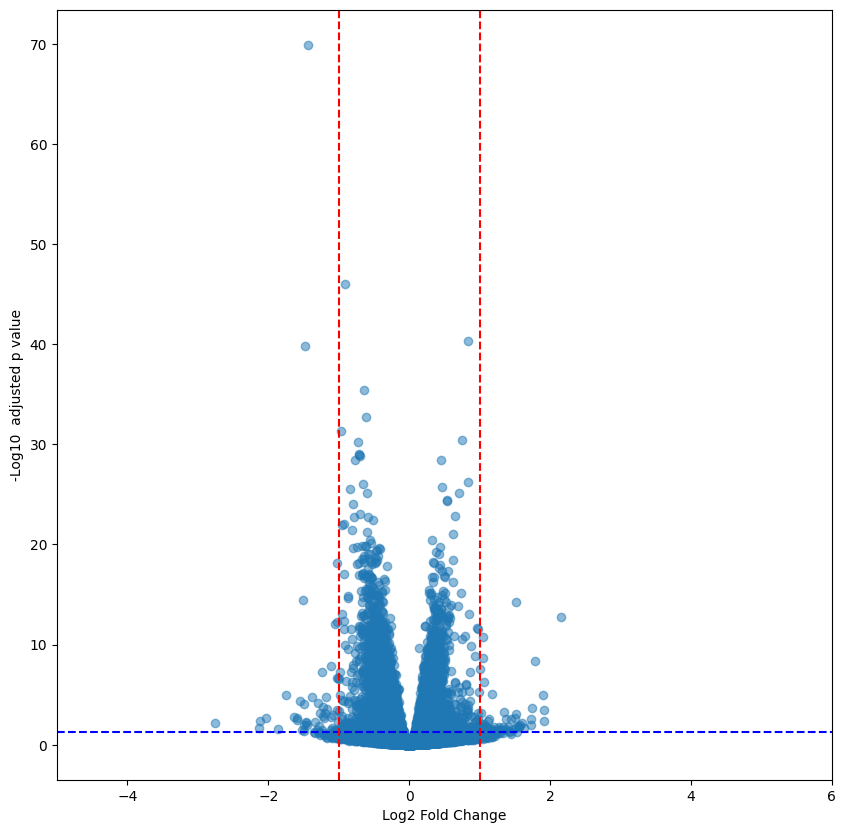

In [ ]:
# SOLUTION
plt.figure(figsize=(10,10))
plt.scatter(DE_results_df.log2FoldChange, -np.log10(DE_results_df.padj), alpha = 0.5)


# Add significance thresholds
plt.axhline(-np.log10(0.05), linestyle="--", color="blue")
plt.axvline(1, linestyle="--", color="red")
plt.axvline(-1, linestyle="--", color="red")
plt.xlim([-5, 6])
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10  adjusted p value")

plt.show()


In [ ]:
upregulated_genes = DE_results_df[(DE_results_df["log2FoldChange"] > 1) &
                           (DE_results_df["padj"] < 0.05)]

print(upregulated_genes.shape)
upregulated_genes.head()
# Save to CSV
upregulated_genes.to_csv("upregulated_genes.csv", index=True)  # Keep index if gene names are there


(56, 7)


In [ ]:
downregulated_genes = DE_results_df[(DE_results_df["log2FoldChange"] < -1) &
                           (DE_results_df["padj"] < 0.05)]

print(downregulated_genes.shape)
downregulated_genes.head()
# Save to CSV
downregulated_genes.to_csv("downregulated_genes.csv", index=True)  # Keep index if gene names are there

(48, 7)


# This is for shTST vs WT

In [ ]:
# differential expression analysis
# no need to edit this block

# Prepare the count matrix (proline_counts)
count_matrix = bulk_data.values  # Convert to numpy array
genes = bulk_data.columns  # Gene names
samples = bulk_data.index  # Sample names

# Prepare the condition labels (kmeans_labels)
condition_labels = rep_cluster_labels  # Condition labels (0 or 1 from k-means)

# Ensure that condition_labels corresponds to the sample order
if len(condition_labels) != len(samples):
    raise ValueError("Condition labels must match the number of samples.")

# 3. Create the DeseqDataSet object
# Create a metadata dataframe for conditions
metadata = pd.DataFrame({'condition': condition_labels}, index=samples)

# Create the DeseqDataSet using count matrix and metadata
dds = DeseqDataSet(counts=count_matrix, metadata=metadata)


# Initialize inference engine
inference = DefaultInference(n_cpus=8)

# Create the DESeq2 dataset
dds = DeseqDataSet(
    counts=count_matrix,
    metadata=metadata,
)

dds.deseq2()
# Extract results
res_sh = DeseqStats(dds, contrast=["condition", "shTST", "WT"])
res_sh.summary()

# Get the results as a DataFrame
DE_results_df_sh = res_sh.results_df
DE_results_df_sh["gene_name"] = list(bulk_data.columns)
display(DE_results_df_sh.head())

Fitting size factors...
... done in 0.04 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 32.75 seconds.

Fitting dispersion trend curve...
... done in 1.00 seconds.

Fitting MAP dispersions...
... done in 38.28 seconds.

Fitting LFCs...
... done in 24.95 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 14.24 seconds.



Log2 fold change & Wald test p-value: condition shTST vs WT
         baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0        0.000000             NaN       NaN       NaN       NaN       NaN
1       44.423694        0.075233  0.239431  0.314216  0.753357  0.871359
2        0.678557        2.489468  2.587534  0.962100  0.335999       NaN
3        0.843199       -3.247927  2.262411 -1.435604  0.151115       NaN
4        0.000000             NaN       NaN       NaN       NaN       NaN
...           ...             ...       ...       ...       ...       ...
57495  206.716906       -0.012399  0.103188 -0.120161  0.904356  0.953383
57496    0.000000             NaN       NaN       NaN       NaN       NaN
57497    0.128624       -1.204370  4.051571 -0.297260  0.766268       NaN
57498    0.318246       -1.934508  3.601006 -0.537213  0.591120       NaN
57499    0.000000             NaN       NaN       NaN       NaN       NaN

[57500 rows x 6 columns]


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
0,0.000000,NaN,NaN,NaN,NaN,NaN,ENSG00000223972
1,44.423694,0.075233,0.239431,0.314216,0.753357,0.871359,ENSG00000227232
2,0.678557,2.489468,2.587534,0.962100,0.335999,NaN,ENSG00000278267
3,0.843199,-3.247927,2.262411,-1.435604,0.151115,NaN,ENSG00000243485
4,0.000000,NaN,NaN,NaN,NaN,NaN,ENSG00000237613


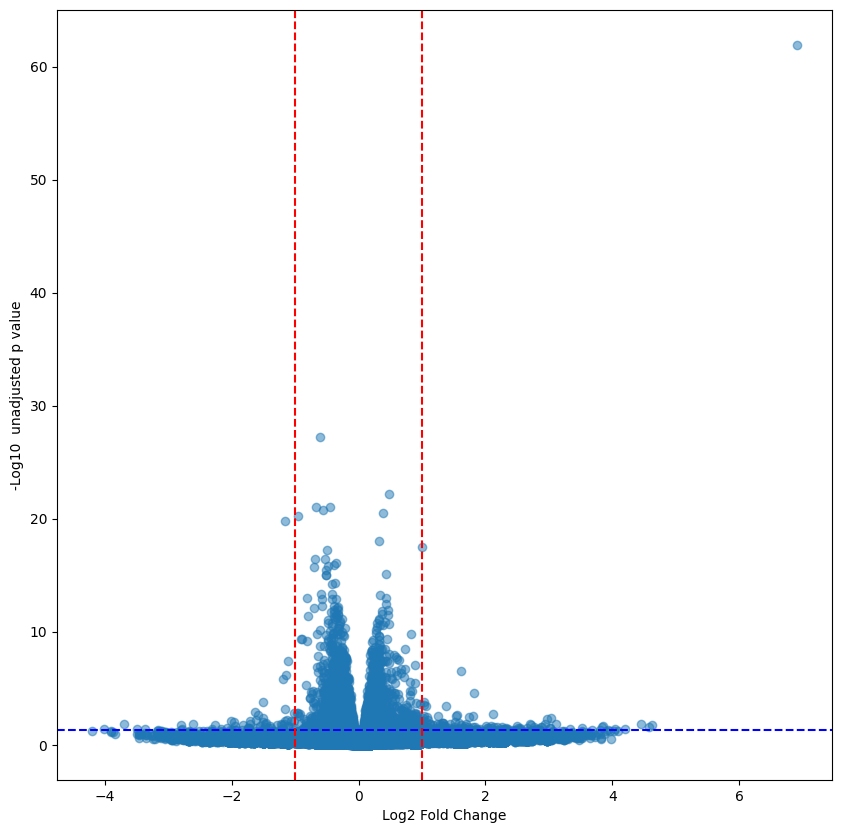

In [ ]:
# SOLUTION
plt.figure(figsize=(10,10))
plt.scatter(DE_results_df_sh.log2FoldChange, -np.log10(DE_results_df_sh.pvalue), alpha = 0.5)


# Add significance thresholds
plt.axhline(-np.log10(0.05), linestyle="--", color="blue")
plt.axvline(1, linestyle="--", color="red")
plt.axvline(-1, linestyle="--", color="red")

plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10  unadjusted p value")

plt.show()


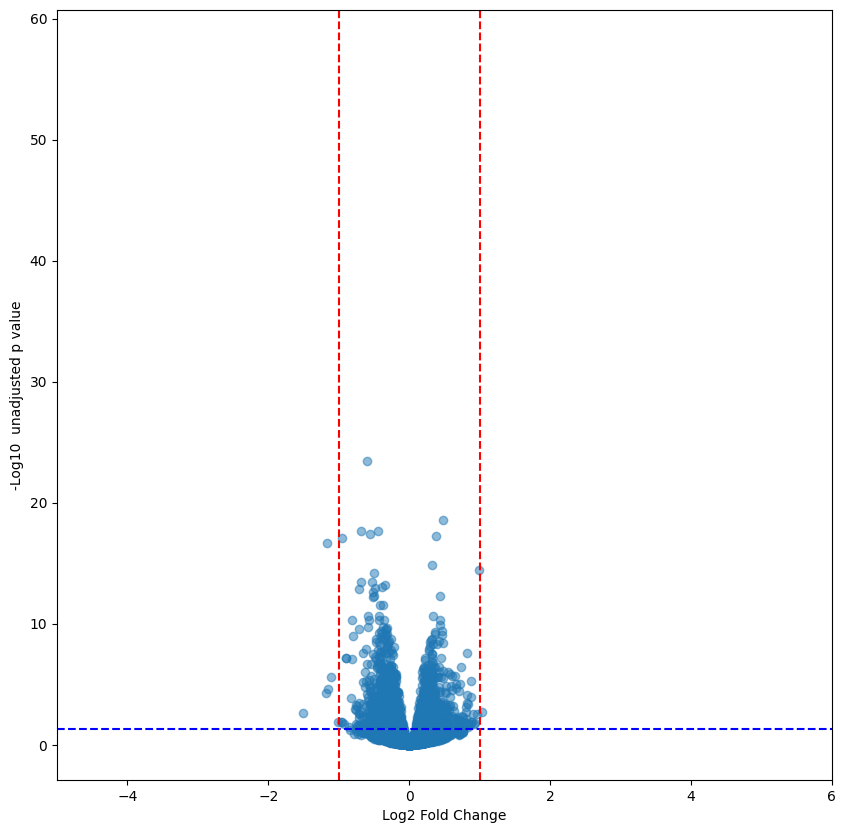

In [ ]:
# SOLUTION
plt.figure(figsize=(10,10))
plt.scatter(DE_results_df_sh.log2FoldChange, -np.log10(DE_results_df_sh.padj), alpha = 0.5)


# Add significance thresholds
plt.axhline(-np.log10(0.05), linestyle="--", color="blue")
plt.axvline(1, linestyle="--", color="red")
plt.axvline(-1, linestyle="--", color="red")
plt.xlim([-5, 6])
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10  unadjusted p value")

plt.show()


In [ ]:
upregulated_genes_sh = DE_results_df_sh[(DE_results_df_sh["log2FoldChange"] > 1) &
                           (DE_results_df_sh["padj"] < 0.05)]

print(upregulated_genes_sh.shape)
upregulated_genes_sh.head()
# Save to CSV
upregulated_genes_sh.to_csv("upregulated_genes_sh.csv", index=True)  # Keep index if gene names are there

(2, 7)


In [ ]:
downregulated_genes_sh = DE_results_df_sh[(DE_results_df_sh["log2FoldChange"] < -1) &
                           (DE_results_df_sh["padj"] < 0.05)]

print(downregulated_genes_sh.shape)
downregulated_genes_sh.head()
# Save to CSV
downregulated_genes_sh.to_csv("downregulated_genes_sh.csv", index=True)  # Keep index if gene names are there

(6, 7)
